In [1]:
from PIL import Image
import scipy as sp
import scipy.ndimage
import scipy.io.wavfile
import numpy as np
import math, wave, struct
import matplotlib.pyplot as plt
import IPython.display
from IPython.display import clear_output

In [2]:
def pltMat(mat):
    mat = np.flip(mat,0)
    X, Y = np.meshgrid(range(mat.shape[0]), range(mat.shape[1]))
    Z = mat[X, Y]
    plt.pcolormesh(Y,X,Z)
    plt.show()

IMAGE BW


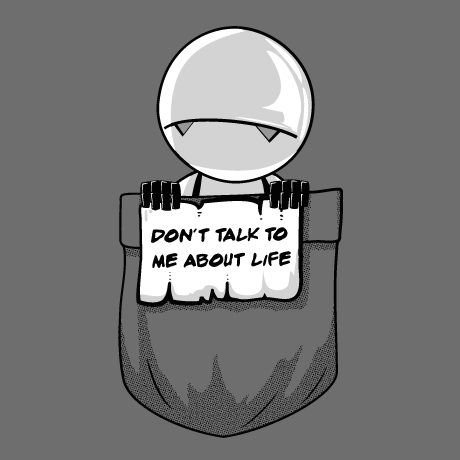

ARRAY IMAGE


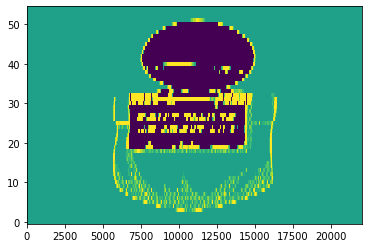

In [3]:
def image_thingy(file, size=(0,0)):
    img = Image.open(file)
    
    img = img.convert("L")

    imgArr = np.array(img)
        
    #aumentar contraste
    imgArr = imgArr/np.max(imgArr)
    imgArr = 1/(imgArr+10**14)
    
    #normalize
    imgArr -= np.min(imgArr)
    imgArr /= np.max(imgArr)
    
    removeLow = np.vectorize(lambda x: x if x > .5 else 0, otypes=[float])
    imgArr = removeLow(imgArr)
    
    #imgArr = 1/imgArr #testar depois TODO
    if size == (0,0): size = imgArr.shape
    
    resamplingFactor = size[0]/imgArr.shape[0], size[1]/imgArr.shape[1]
    imgArr = sp.ndimage.zoom(imgArr, resamplingFactor, order=0)
    
    print("IMAGE BW")
    display(img)
    print("ARRAY IMAGE")
    pltMat(imgArr)
    return imgArr
image_thingy("image.png", size=(55,22050))
print()

In [18]:
def pltSpec(file):
    sample_rate, X = scipy.io.wavfile.read(file)
    plt.specgram(X, Fs=sample_rate)

IMAGE BW


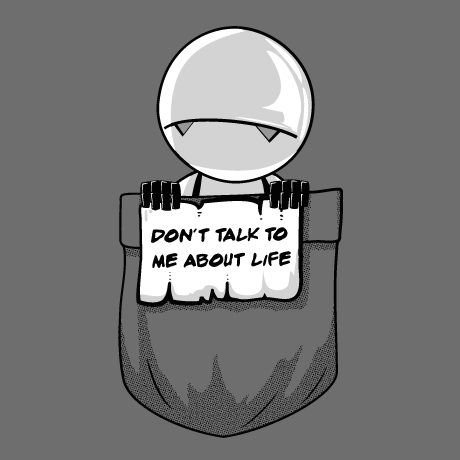

ARRAY IMAGE


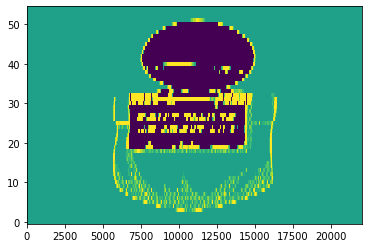

Spectrogram


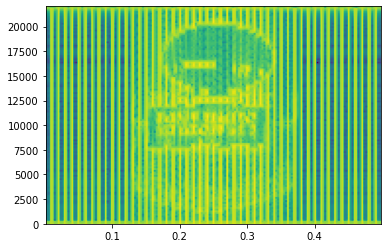

In [19]:
def genSound(file):
    sample_rate = 44100
    duration = .5
    
    wavef = wave.open("sound.wav", "w")
    wavef.setnchannels(1)
    wavef.setsampwidth(2)
    wavef.setframerate(sample_rate)
    
    max_frame = int(duration*sample_rate)
    max_freq = 22000
    max_intensity = 32767 #int16
    
    stepSize = 400
    steppingSepctrum = int(max_freq/stepSize)
    
    #print(steppingSepctrum, max_frame)
    imgMat = image_thingy(file, (steppingSepctrum, max_frame))

    imgMat *= max_intensity
    for frame in range(max_frame):
        signalValue, count = 0, 0
        for step in range(steppingSepctrum):
            intensity = imgMat[step, frame]
            if intensity == 0:
                continue
            currentFreq = max_freq - step * stepSize
            nextFreq = max_freq - (step+1)*stepSize
            if nextFreq < 0: #end of spectrum
                nextFreq = 0
            for freq in range(nextFreq, currentFreq, 100):
                signalValue += intensity*math.cos(freq * 2 * math.pi * float(frame)/float(sample_rate))
                count += 1
        if count == 0: count = 1
        signalValue /= count
        data = struct.pack("<h", int(signalValue))
        wavef.writeframesraw( data )
    wavef.writeframes(''.encode())
    wavef.close()
    print("Spectrogram")
    pltSpec("sound.wav")
genSound("image.png")

In [19]:
sample_rate, wave_data = scipy.io.wavfile.read("sound.wav")
duration = wave_data.size/sample_rate

step = 100
iterations = wave_data.size//step

In [254]:
data = None
for iteration in range(iterations):
    
    #take interval
    interval = wave_data[iteration*step : (iteration+1)*step]
    
    #padding with zeros
    interval = np.concatenate((interval, np.zeros(step*2)))
    
    
    #window function
    #wf = np.sin(2*np.pi*np.ones_like(interval)/(step*2))
    #wf = -np.cos(2*np.pi*np.arange(step, interval.size + step, 1)/(step*3))
    wf = np.exp(- (1.5*(np.arange(-interval.size//2, interval.size//2, 1) + step)/step)**2 )
    
    interval = interval * wf
    
    
    values = abs(np.fft.fft(interval))
    values = 30*np.log10(values)[values.size//2:]
    freqs = np.array([values]).T
    
    if data is None:
        data = freqs
    else:
        data = np.concatenate((data, freqs), axis=1)
    

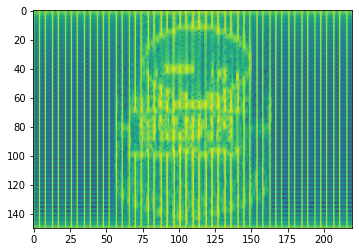

In [255]:
plt.imshow(data)

# WAVELET

In [35]:
#WAVELET TRANSFORM
def morlet(t, b, f, sig):
    tb = t-b
    return np.exp(1j*2*np.pi*f*tb)*np.exp(-.5 * (tb/sig)**2)

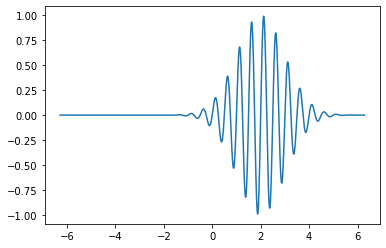

In [78]:
t = np.linspace(-2*np.pi, 2*np.pi, 1000)
plt.plot(t,morlet(t, 2, 2, 1).imag)

In [84]:
wave_data.size

22050

In [87]:
np.arange(0, wave_data.size, 0.5)

array([0.00000e+00, 5.00000e-01, 1.00000e+00, ..., 2.20485e+04,
       2.20490e+04, 2.20495e+04])

In [ ]:
max_freq = 22000

t           = np.arange(0, wave_data.size, 5)
frequencies = np.arange(0, max_freq, 5)

data = np.zeros((frequencies.size, t.size))
                 

                 
for ti, dt in enumerate(t):
    for fi, frequency in enumerate(frequencies):
        clear_output(wait=True)
        print(f"{dt=} | {frequency=}")
        #take interval
    
        interval = wave_data.copy()
        #no need for padding
        #interval = np.concatenate((interval, np.zeros(step)))
    
    
        #no need for a window function
        #wf = np.sin(2*np.pi*np.ones_like(interval)/(step*2))
        
        #dot product in the hilbert space
        interval = interval[::5] * morlet(t, dt, frequency, 1)
    
    
        #values = abs(np.fft.fft(interval))
        #values = 20*np.log10(values)[values.size//2:]
        value = abs(interval).sum()
    
        data[fi, ti] = value
        #if data is None:
        #    data = time_frame
        #else:
        #    data = np.concatenate((data, time_frame), axis=1)
data = 20*np.log10(data)
plt.imshow(data)

dt=935 | frequency=10060


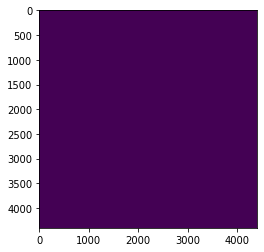

In [129]:
max_freq = 22000
t           = np.arange(0, wave_data.size, 5)
frequencies = np.arange(0, max_freq, 5)

data = np.zeros((frequencies.size, t.size))
plt.imshow(data)

In [132]:
t.size

4410